# PETase ESM3 Embedding Generation

**Project**: 2025 PETase Tournament  
**Purpose**: Generate sequence and structure embeddings for Tm prediction

---

## Overview

| Embedding Type | Source | Output Dim | Samples |
|----------------|--------|------------|----------|
| Sequence | Protein sequence | 1536 | 116 |
| Structure | PDB/FoldX template | 1536 | ~95 |

## 1. Setup Environment

In [1]:
# Install ESM3 and dependencies
!pip install esm torch pandas openpyxl tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 122.0 

In [2]:
import torch
import time  # <-- Add this line!
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
BASE_DIR = Path('/content/drive/MyDrive/PET2025/playground')
DATA_DIR = BASE_DIR / 'data'
OUTPUT_DIR = BASE_DIR / 'embeddings'

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Mounted at /content/drive
Base directory: /content/drive/MyDrive/PET2025/playground
Data directory: /content/drive/MyDrive/PET2025/playground/data
Output directory: /content/drive/MyDrive/PET2025/playground/embeddings


## 2. Load Data

In [4]:
# ================================================
# Path to the csv files
# ================================================
# input files
TEST_CSV = Path("/content/drive/MyDrive/PET2025/playground/data/predictive-pet-zero-shot-test-2025.csv")
WT_CSV = Path("/content/drive/MyDrive/PET2025/playground/data/pet-2025-wildtype-cds.csv")

# outputs
OUTPUT_DIR = Path("/content/drive/MyDrive/PET2025/playground/mutation_scores")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## ESM Forge API

In [5]:
from esm.sdk import client as esm_client
from esm.sdk.api import ESMProtein, LogitsConfig
from getpass import getpass

# 4KmDJvB1gQaRJJDrWoBa91
token = getpass("🔑 Forge API Token: ")

# model connection
model = esm_client(
    model="esm3-open",
    url="https://forge.evolutionaryscale.ai",
    token=token
)

print("✅ Connected to ESM3 Forge API")

🔑 Forge API Token: ··········
✅ Connected to ESM3 Forge API


## Load data

In [6]:
test_df = pd.read_csv(TEST_CSV)
wt_df = pd.read_csv(WT_CSV)

print(f"Test sequences: {len(test_df)}")
print(f"Wild-type sequences: {len(wt_df)}")

# wild type sequences
wt_sequences = set(wt_df['Wt AA Sequence'].tolist())
wt_list = wt_df['Wt AA Sequence'].tolist()

Test sequences: 4988
Wild-type sequences: 313


## Core

In [7]:
probe_seq = wt_list[0][:50]  # Use first 50 residues for quick test

print(f"Testing API with probe sequence (length={len(probe_seq)})...")

protein = ESMProtein(sequence=probe_seq)
encoded = model.encode(protein)
output = model.logits(encoded, LogitsConfig(sequence=True, return_embeddings=True))

print(f"✅ API test successful!")
print(f"   Logits type: {type(output.logits)}")
if hasattr(output.logits, 'shape'):
    print(f"   Logits shape: {output.logits.shape}")

Testing API with probe sequence (length=50)...
✅ API test successful!
   Logits type: <class 'esm.sdk.api.ForwardTrackData'>


In [8]:
# Standard 20 amino acids
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

# ESM3 token mapping (based on ESM model vocabulary)
# These indices correspond to the vocabulary positions
AA_TO_IDX = {
    'A': 5,  'C': 23, 'D': 13, 'E': 9,  'F': 18,
    'G': 6,  'H': 21, 'I': 12, 'K': 15, 'L': 4,
    'M': 20, 'N': 17, 'P': 14, 'Q': 16, 'R': 10,
    'S': 8,  'T': 11, 'V': 7,  'W': 22, 'Y': 19
}

# Reverse mapping for debugging
IDX_TO_AA = {v: k for k, v in AA_TO_IDX.items()}

print("Amino acid to token index mapping:")
print(AA_TO_IDX)

Amino acid to token index mapping:
{'A': 5, 'C': 23, 'D': 13, 'E': 9, 'F': 18, 'G': 6, 'H': 21, 'I': 12, 'K': 15, 'L': 4, 'M': 20, 'N': 17, 'P': 14, 'Q': 16, 'R': 10, 'S': 8, 'T': 11, 'V': 7, 'W': 22, 'Y': 19}


In [9]:
# ================================================
# Cell 8: Core function - Get position-wise logits (FIXED)
# ================================================

def get_position_logits(sequence):
    """
    Get amino acid logits for each position in a sequence.

    Args:
        sequence: Amino acid sequence string

    Returns:
        numpy array of shape (seq_len, vocab_size) containing logits
    """
    protein = ESMProtein(sequence=sequence)
    encoded = model.encode(protein)

    # Get logits with sequence=True
    output = model.logits(encoded, LogitsConfig(sequence=True, return_embeddings=True))

    # Extract logits tensor
    logits = output.logits
    if hasattr(logits, 'sequence'):
        logits = logits.sequence

    # Convert to numpy array
    # FIX: ESM3 returns BFloat16, which numpy doesn't support
    # Must convert to float32 first
    if isinstance(logits, torch.Tensor):
        logits = logits.detach().to(torch.float32).cpu().numpy()
    else:
        logits = np.array(logits, dtype=np.float32)

    # Handle shape: could be (1, L, V) or (L, V)
    if logits.ndim == 3:
        logits = logits[0]  # Remove batch dimension

    return logits.astype(np.float32)


def logits_to_log_probs(logits):
    """
    Convert logits to log probabilities using log-softmax.
    """
    # Numerically stable log-softmax
    max_logits = np.max(logits, axis=-1, keepdims=True)
    shifted_logits = logits - max_logits
    exp_logits = np.exp(shifted_logits)
    sum_exp = np.sum(exp_logits, axis=-1, keepdims=True)
    log_probs = shifted_logits - np.log(sum_exp)
    return log_probs


# Test the functions
print("Testing get_position_logits()...")
test_logits = get_position_logits(probe_seq)
print(f"✅ Logits shape: {test_logits.shape}")
print(f"   Expected: ({len(probe_seq)}, vocab_size)")
print(f"   Dtype: {test_logits.dtype}")

test_log_probs = logits_to_log_probs(test_logits)
print(f"✅ Log probs shape: {test_log_probs.shape}")
print(f"   Log prob range: [{test_log_probs.min():.2f}, {test_log_probs.max():.2f}]")

Testing get_position_logits()...
✅ Logits shape: (52, 64)
   Expected: (50, vocab_size)
   Dtype: float32
✅ Log probs shape: (52, 64)
   Log prob range: [-23.43, -0.70]


In [10]:
# ================================================
# Cell 9: Find parent wild-type for each mutant
# ================================================

def find_parent_wildtype(mut_seq, wt_sequences_list):
    """
    Find the parent wild-type sequence for a mutant.
    Single-point mutants differ from their parent by exactly 1 amino acid.

    Args:
        mut_seq: Mutant sequence string
        wt_sequences_list: List of wild-type sequences

    Returns:
        Parent wild-type sequence string, or None if not found
    """
    mut_len = len(mut_seq)

    for wt_seq in wt_sequences_list:
        if len(wt_seq) != mut_len:
            continue

        # Count differences
        diff_count = sum(1 for a, b in zip(wt_seq, mut_seq) if a != b)

        if diff_count == 1:
            return wt_seq  # Single-point mutant
        elif diff_count == 0:
            return wt_seq  # Identical (is wild-type)

    return None


def find_mutation_details(wt_seq, mut_seq):
    """
    Find the specific mutation between wild-type and mutant sequences.

    Args:
        wt_seq: Wild-type sequence string
        mut_seq: Mutant sequence string

    Returns:
        Dictionary with 'position', 'wt_aa', 'mut_aa' keys, or None if identical
    """
    if wt_seq is None or len(wt_seq) != len(mut_seq):
        return None

    for i, (w, m) in enumerate(zip(wt_seq, mut_seq)):
        if w != m:
            return {
                'position': i,      # 0-indexed position
                'wt_aa': w,         # Original amino acid
                'mut_aa': m         # Mutated amino acid
            }

    return None  # Sequences are identical

# Test the functions
print("Testing parent wild-type finder...")
test_seq = test_df.iloc[100]['sequence']  # Pick a random test sequence
parent = find_parent_wildtype(test_seq, wt_list)

if parent:
    mutation = find_mutation_details(parent, test_seq)
    if mutation:
        print(f"✅ Found mutation: {mutation['wt_aa']}{mutation['position']+1}{mutation['mut_aa']}")
    else:
        print(f"✅ Sequence is identical to wild-type")
else:
    print(f"⚠️ No parent wild-type found for this sequence")

Testing parent wild-type finder...
✅ Found mutation: S49L


In [11]:
# ================================================
# Cell 10: Compute mutation Log-Likelihood Ratio (LLR)
# ================================================

def compute_mutation_llr(wt_sequence, mut_sequence, aa_to_idx=None):
    """
    Compute the Log-Likelihood Ratio (LLR) for a mutation.

    LLR = log P(mut_aa | context) - log P(wt_aa | context)

    We use the wild-type sequence context to compute probabilities,
    which represents how the model views each amino acid at that position.

    Args:
        wt_sequence: Wild-type sequence string
        mut_sequence: Mutant sequence string
        aa_to_idx: Dictionary mapping amino acids to token indices

    Returns:
        float: LLR value
            Positive = mutation is evolutionarily favorable
            Negative = mutation is evolutionarily unfavorable
            Zero = neutral or identical sequences
    """
    if aa_to_idx is None:
        aa_to_idx = AA_TO_IDX

    # Find mutation position and amino acids
    mutation = find_mutation_details(wt_sequence, mut_sequence)
    if mutation is None:
        return 0.0  # Identical sequences

    pos = mutation['position']
    wt_aa = mutation['wt_aa']
    mut_aa = mutation['mut_aa']

    # Get logits for wild-type sequence
    # This represents P(AA | wild-type context) for each position
    logits = get_position_logits(wt_sequence)
    log_probs = logits_to_log_probs(logits)

    # Get log probabilities at mutation position
    try:
        pos_log_probs = log_probs[pos]

        wt_idx = aa_to_idx.get(wt_aa)
        mut_idx = aa_to_idx.get(mut_aa)

        if wt_idx is None or mut_idx is None:
            print(f"Warning: Unknown amino acid - wt:{wt_aa}, mut:{mut_aa}")
            return np.nan

        # LLR = log P(mutant) - log P(wildtype)
        llr = float(pos_log_probs[mut_idx] - pos_log_probs[wt_idx])
        return llr

    except IndexError as e:
        print(f"Error: Position {pos} out of range for logits shape {log_probs.shape}")
        return np.nan

In [12]:
# ================================================
# Cell 11: Compute sequence Pseudo-Likelihood (PLL)
# ================================================

def compute_sequence_pseudo_likelihood(sequence, aa_to_idx=None):
    """
    Compute the Pseudo-Likelihood (PLL) of a sequence.

    PLL = (1/L) * Σ log P(aa_i | context)

    This measures how "natural" or "protein-like" a sequence is according to ESM3.
    Higher PLL = sequence is more consistent with natural protein patterns.

    Args:
        sequence: Amino acid sequence string
        aa_to_idx: Dictionary mapping amino acids to token indices

    Returns:
        float: Average log probability per residue
    """
    if aa_to_idx is None:
        aa_to_idx = AA_TO_IDX

    logits = get_position_logits(sequence)
    log_probs = logits_to_log_probs(logits)

    total_ll = 0.0
    count = 0

    for i, aa in enumerate(sequence):
        if aa in aa_to_idx:
            aa_idx = aa_to_idx[aa]
            try:
                total_ll += log_probs[i, aa_idx]
                count += 1
            except IndexError:
                continue

    if count == 0:
        return np.nan

    return total_ll / count

# Test LLR and PLL computation
print("\nTesting LLR and PLL computation...")
if parent and mutation:
    test_llr = compute_mutation_llr(parent, test_seq)
    test_pll = compute_sequence_pseudo_likelihood(test_seq)
    print(f"✅ Mutation LLR: {test_llr:.4f}")
    print(f"✅ Sequence PLL: {test_pll:.4f}")


Testing LLR and PLL computation...
✅ Mutation LLR: -0.1484
✅ Sequence PLL: -5.2357


In [13]:
# ================================================
# Cell 12: Batch processing function with checkpointing
# ================================================

def process_all_mutations(test_df, wt_list, wt_sequences_set, output_path,
                          checkpoint_every=100,
                          rate_limit_delay=0.2,
                          start_from=0):
    """
    Process all test sequences and compute mutation scores.

    Features:
    - Automatic checkpointing for crash recovery
    - Rate limiting to avoid API throttling
    - Progress tracking with tqdm

    Args:
        test_df: DataFrame with test sequences
        wt_list: List of wild-type sequences
        wt_sequences_set: Set of wild-type sequences for O(1) lookup
        output_path: Path to save output CSV
        checkpoint_every: Save checkpoint every N sequences
        rate_limit_delay: Delay between API calls in seconds
        start_from: Index to start from (for manual resume)

    Returns:
        DataFrame with mutation scores
    """

    results = []
    checkpoint_path = output_path.parent / "checkpoint.csv"
    start_idx = start_from

    # Check for existing checkpoint
    if checkpoint_path.exists() and start_from == 0:
        checkpoint_df = pd.read_csv(checkpoint_path)
        results = checkpoint_df.to_dict('records')
        start_idx = len(results)
        print(f"📂 Resuming from checkpoint at index {start_idx}")

    # Process each sequence
    for idx in tqdm(range(start_idx, len(test_df)), initial=start_idx, total=len(test_df)):
        row = test_df.iloc[idx]
        seq = row['sequence']

        try:
            # Check if sequence is a wild-type
            is_wt = seq in wt_sequences_set

            if is_wt:
                # Wild-type: compute PLL only, LLR is 0
                pll = compute_sequence_pseudo_likelihood(seq)
                results.append({
                    'index': idx,
                    'sequence': seq,
                    'is_wildtype': True,
                    'parent_wt': seq,
                    'mutation_position': None,
                    'wt_aa': None,
                    'mut_aa': None,
                    'mutation_llr': 0.0,
                    'pseudo_likelihood': pll
                })
            else:
                # Find parent wild-type
                parent_wt = find_parent_wildtype(seq, wt_list)

                if parent_wt is None:
                    # Could not find parent wild-type
                    results.append({
                        'index': idx,
                        'sequence': seq,
                        'is_wildtype': False,
                        'parent_wt': None,
                        'mutation_position': None,
                        'wt_aa': None,
                        'mut_aa': None,
                        'mutation_llr': np.nan,
                        'pseudo_likelihood': np.nan
                    })
                else:
                    # Compute mutation scores
                    mutation = find_mutation_details(parent_wt, seq)
                    llr = compute_mutation_llr(parent_wt, seq)
                    pll = compute_sequence_pseudo_likelihood(seq)

                    results.append({
                        'index': idx,
                        'sequence': seq,
                        'is_wildtype': False,
                        'parent_wt': parent_wt,
                        'mutation_position': mutation['position'] if mutation else None,
                        'wt_aa': mutation['wt_aa'] if mutation else None,
                        'mut_aa': mutation['mut_aa'] if mutation else None,
                        'mutation_llr': llr,
                        'pseudo_likelihood': pll
                    })

            # Rate limiting to avoid API throttling
            time.sleep(rate_limit_delay)

        except Exception as e:
            print(f"\n⚠️ Error at index {idx}: {e}")
            results.append({
                'index': idx,
                'sequence': seq,
                'is_wildtype': False,
                'parent_wt': None,
                'mutation_position': None,
                'wt_aa': None,
                'mut_aa': None,
                'mutation_llr': np.nan,
                'pseudo_likelihood': np.nan,
                'error': str(e)
            })

        # Save checkpoint periodically
        if (idx + 1) % checkpoint_every == 0:
            checkpoint_df = pd.DataFrame(results)
            checkpoint_df.to_csv(checkpoint_path, index=False)
            print(f"\n💾 Checkpoint saved at index {idx + 1}")

    # Save final results
    final_df = pd.DataFrame(results)
    final_df.to_csv(output_path, index=False)

    # Remove checkpoint file
    if checkpoint_path.exists():
        checkpoint_path.unlink()
        print("🗑️ Checkpoint file removed")

    print(f"\n✅ Complete! Results saved to {output_path}")
    return final_df

In [14]:
# ================================================
# Cell 13: Run the full pipeline (TEST MODE - first 20 sequences)
# ================================================

# Test with a small subset first
print("=" * 60)
print("RUNNING TEST MODE: Processing first 20 sequences")
print("=" * 60)

TEST_OUTPUT = OUTPUT_DIR / "mutation_scores_test.csv"
test_subset = test_df.head(20)

results_test = process_all_mutations(
    test_subset,
    wt_list,
    wt_sequences,
    TEST_OUTPUT,
    checkpoint_every=10,
    rate_limit_delay=0.15
)

print("\n--- Test Results Summary ---")
print(results_test[['is_wildtype', 'mutation_llr', 'pseudo_likelihood']].describe())

RUNNING TEST MODE: Processing first 20 sequences


 50%|█████     | 10/20 [00:07<00:07,  1.29it/s]


💾 Checkpoint saved at index 10


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


💾 Checkpoint saved at index 20


🗑️ Checkpoint file removed

✅ Complete! Results saved to /content/drive/MyDrive/PET2025/playground/mutation_scores/mutation_scores_test.csv

--- Test Results Summary ---
       mutation_llr  pseudo_likelihood
count     20.000000          20.000000
mean      -1.080725          -5.229792
std        2.688148           0.034163
min       -7.468750          -5.304517
25%       -2.265625          -5.247414
50%       -0.651978          -5.222085
75%        0.500000          -5.203774
max        3.000000          -5.186552


In [ ]:
# ================================================
# Cell 14: Run FULL pipeline (uncomment to run)
# ================================================

# ⚠️ WARNING: This will process all 4988 sequences
# Estimated time: 1.5-2 hours
# Uncomment the lines below to run the full pipeline

print("=" * 60)
print("RUNNING FULL PIPELINE: Processing all sequences")
print("=" * 60)

FULL_OUTPUT = OUTPUT_DIR / "mutation_scores_full.csv"

results_full = process_all_mutations(
    test_df,
    wt_list,
    wt_sequences,
    FULL_OUTPUT,
    checkpoint_every=100,
    rate_limit_delay=0.15
)

RUNNING FULL PIPELINE: Processing all sequences


  2%|▏         | 100/4988 [01:15<1:01:25,  1.33it/s]


💾 Checkpoint saved at index 100


  4%|▍         | 200/4988 [02:30<1:00:29,  1.32it/s]


💾 Checkpoint saved at index 200


  6%|▌         | 300/4988 [03:46<1:00:26,  1.29it/s]


💾 Checkpoint saved at index 300


  8%|▊         | 400/4988 [05:01<57:25,  1.33it/s]


💾 Checkpoint saved at index 400


 10%|█         | 500/4988 [06:16<56:26,  1.33it/s]


💾 Checkpoint saved at index 500


 12%|█▏        | 600/4988 [07:31<56:02,  1.30it/s]


💾 Checkpoint saved at index 600


 14%|█▍        | 700/4988 [08:46<54:40,  1.31it/s]


💾 Checkpoint saved at index 700


 16%|█▌        | 800/4988 [10:04<55:43,  1.25it/s]


💾 Checkpoint saved at index 800


 18%|█▊        | 900/4988 [11:21<51:57,  1.31it/s]


💾 Checkpoint saved at index 900


 20%|██        | 1000/4988 [12:37<50:46,  1.31it/s]


💾 Checkpoint saved at index 1000


 22%|██▏       | 1100/4988 [13:52<48:52,  1.33it/s]


💾 Checkpoint saved at index 1100


 24%|██▍       | 1200/4988 [15:07<48:59,  1.29it/s]


💾 Checkpoint saved at index 1200


 26%|██▌       | 1300/4988 [16:23<48:57,  1.26it/s]


💾 Checkpoint saved at index 1300


 28%|██▊       | 1400/4988 [17:41<47:32,  1.26it/s]


💾 Checkpoint saved at index 1400


 30%|███       | 1500/4988 [18:59<44:22,  1.31it/s]


💾 Checkpoint saved at index 1500


 32%|███▏      | 1600/4988 [20:17<44:38,  1.26it/s]


💾 Checkpoint saved at index 1600


 34%|███▍      | 1700/4988 [21:34<43:25,  1.26it/s]


💾 Checkpoint saved at index 1700


 36%|███▌      | 1800/4988 [22:53<42:14,  1.26it/s]


💾 Checkpoint saved at index 1800


 38%|███▊      | 1900/4988 [24:09<39:12,  1.31it/s]


💾 Checkpoint saved at index 1900


 40%|████      | 2000/4988 [25:24<37:54,  1.31it/s]


💾 Checkpoint saved at index 2000


 42%|████▏     | 2100/4988 [26:39<36:49,  1.31it/s]


💾 Checkpoint saved at index 2100


 44%|████▍     | 2200/4988 [27:54<35:09,  1.32it/s]


💾 Checkpoint saved at index 2200


 46%|████▌     | 2300/4988 [29:09<34:26,  1.30it/s]


💾 Checkpoint saved at index 2300


 48%|████▊     | 2400/4988 [30:27<34:29,  1.25it/s]


💾 Checkpoint saved at index 2400


 50%|█████     | 2500/4988 [31:45<32:03,  1.29it/s]


💾 Checkpoint saved at index 2500


 52%|█████▏    | 2600/4988 [32:59<31:01,  1.28it/s]


💾 Checkpoint saved at index 2600


 54%|█████▍    | 2700/4988 [34:14<29:00,  1.31it/s]


💾 Checkpoint saved at index 2700


 56%|█████▌    | 2800/4988 [35:29<28:03,  1.30it/s]


💾 Checkpoint saved at index 2800


 58%|█████▊    | 2900/4988 [36:45<26:54,  1.29it/s]


💾 Checkpoint saved at index 2900


 60%|██████    | 3000/4988 [38:00<25:33,  1.30it/s]


💾 Checkpoint saved at index 3000


 62%|██████▏   | 3100/4988 [39:15<24:13,  1.30it/s]


💾 Checkpoint saved at index 3100


 64%|██████▍   | 3200/4988 [40:29<22:38,  1.32it/s]


💾 Checkpoint saved at index 3200


 66%|██████▌   | 3300/4988 [41:44<21:52,  1.29it/s]


💾 Checkpoint saved at index 3300


 68%|██████▊   | 3400/4988 [42:58<20:20,  1.30it/s]


💾 Checkpoint saved at index 3400


 70%|███████   | 3500/4988 [44:13<18:50,  1.32it/s]


💾 Checkpoint saved at index 3500


 72%|███████▏  | 3600/4988 [45:27<17:38,  1.31it/s]


💾 Checkpoint saved at index 3600


 74%|███████▍  | 3700/4988 [46:42<16:45,  1.28it/s]


💾 Checkpoint saved at index 3700


 76%|███████▌  | 3800/4988 [47:58<17:10,  1.15it/s]


💾 Checkpoint saved at index 3800


 78%|███████▊  | 3900/4988 [49:15<14:37,  1.24it/s]


💾 Checkpoint saved at index 3900


 80%|████████  | 4000/4988 [50:32<12:44,  1.29it/s]


💾 Checkpoint saved at index 4000


 82%|████████▏ | 4100/4988 [51:50<12:32,  1.18it/s]


💾 Checkpoint saved at index 4100


 84%|████████▍ | 4200/4988 [53:05<10:20,  1.27it/s]


💾 Checkpoint saved at index 4200


 86%|████████▌ | 4300/4988 [54:20<08:49,  1.30it/s]


💾 Checkpoint saved at index 4300


 88%|████████▊ | 4400/4988 [55:35<07:39,  1.28it/s]


💾 Checkpoint saved at index 4400


 90%|█████████ | 4500/4988 [56:50<06:17,  1.29it/s]


💾 Checkpoint saved at index 4500


 92%|█████████▏| 4600/4988 [58:05<04:55,  1.31it/s]


💾 Checkpoint saved at index 4600


 94%|█████████▍| 4700/4988 [59:13<02:16,  2.10it/s]


💾 Checkpoint saved at index 4700


 96%|█████████▌| 4800/4988 [1:00:00<01:33,  2.02it/s]


💾 Checkpoint saved at index 4800


 98%|█████████▊| 4900/4988 [1:00:46<00:43,  2.01it/s]


💾 Checkpoint saved at index 4900


100%|██████████| 4988/4988 [1:01:25<00:00,  1.35it/s]

🗑️ Checkpoint file removed

✅ Complete! Results saved to /content/drive/MyDrive/PET2025/playground/mutation_scores/mutation_scores_full.csv


In [ ]:
# ================================================
# Cell 15: Analyze results
# ================================================

# Load results (use test results or load full results)
results_df = results_full  # Change to results_full for full analysis

print("\n" + "=" * 60)
print("MUTATION SCORING RESULTS SUMMARY")
print("=" * 60)

print(f"\nTotal sequences processed: {len(results_df)}")
print(f"Wild-types identified: {results_df['is_wildtype'].sum()}")
print(f"Mutants identified: {(~results_df['is_wildtype']).sum()}")
print(f"Missing parent WT: {results_df['parent_wt'].isna().sum()}")

print("\n--- LLR Statistics (Mutants only) ---")
mutant_df = results_df[~results_df['is_wildtype']]
llr_valid = mutant_df['mutation_llr'].dropna()

if len(llr_valid) > 0:
    print(f"Mean LLR: {llr_valid.mean():.4f}")
    print(f"Std LLR:  {llr_valid.std():.4f}")
    print(f"Min LLR:  {llr_valid.min():.4f}")
    print(f"Max LLR:  {llr_valid.max():.4f}")
    print(f"Median:   {llr_valid.median():.4f}")

print("\n--- Pseudo-Likelihood Statistics ---")
pll_valid = results_df['pseudo_likelihood'].dropna()

if len(pll_valid) > 0:
    print(f"Mean PLL: {pll_valid.mean():.4f}")
    print(f"Std PLL:  {pll_valid.std():.4f}")
    print(f"Min PLL:  {pll_valid.min():.4f}")
    print(f"Max PLL:  {pll_valid.max():.4f}")


MUTATION SCORING RESULTS SUMMARY

Total sequences processed: 4988
Wild-types identified: 314
Mutants identified: 4674
Missing parent WT: 0

--- LLR Statistics (Mutants only) ---
Mean LLR: -1.0595
Std LLR:  4.0822
Min LLR:  -18.4062
Max LLR:  15.2812
Median:   -0.9385

--- Pseudo-Likelihood Statistics ---
Mean PLL: -5.4181
Std PLL:  0.2709
Min PLL:  -6.2691
Max PLL:  -4.1825


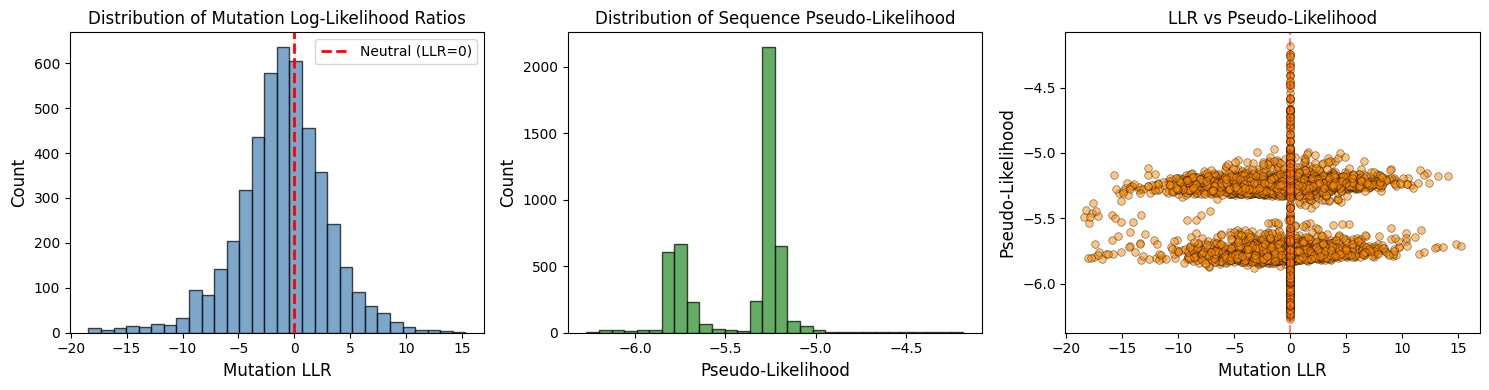


📊 Figure saved to /content/drive/MyDrive/PET2025/playground/mutation_scores/mutation_scores_distribution.png


In [ ]:
# ================================================
# Cell 16: Visualize results
# ================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: LLR distribution
ax1 = axes[0]
if len(llr_valid) > 0:
    ax1.hist(llr_valid, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (LLR=0)')
    ax1.set_xlabel('Mutation LLR', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Distribution of Mutation Log-Likelihood Ratios', fontsize=12)
    ax1.legend()

# Plot 2: PLL distribution
ax2 = axes[1]
if len(pll_valid) > 0:
    ax2.hist(pll_valid, bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
    ax2.set_xlabel('Pseudo-Likelihood', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Distribution of Sequence Pseudo-Likelihood', fontsize=12)

# Plot 3: LLR vs PLL scatter
ax3 = axes[2]
valid_mask = results_df['mutation_llr'].notna() & results_df['pseudo_likelihood'].notna()
if valid_mask.sum() > 0:
    ax3.scatter(
        results_df.loc[valid_mask, 'mutation_llr'],
        results_df.loc[valid_mask, 'pseudo_likelihood'],
        alpha=0.5, s=30, c='darkorange', edgecolor='black', linewidth=0.5
    )
    ax3.set_xlabel('Mutation LLR', fontsize=12)
    ax3.set_ylabel('Pseudo-Likelihood', fontsize=12)
    ax3.set_title('LLR vs Pseudo-Likelihood', fontsize=12)
    ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mutation_scores_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Figure saved to {OUTPUT_DIR / 'mutation_scores_distribution.png'}")

In [ ]:
# ================================================
# Cell 17: Predict activity using LLR-based heuristic
# ================================================

def predict_activity_from_scores(results_df, ph='5.5'):
    """
    Predict enzyme activity using mutation LLR and PLL scores.

    Assumptions:
    - LLR > 0: Beneficial mutation, activity may increase
    - LLR ≈ 0: Neutral mutation, activity maintained
    - LLR < 0: Deleterious mutation, activity may decrease
    - Higher PLL: More "natural" sequence, likely functional

    Args:
        results_df: DataFrame with mutation scores
        ph: pH condition ('5.5' or '9.0')

    Returns:
        numpy array of predicted activity values
    """

    # Normalize LLR to 0-1 range using sigmoid
    llr = results_df['mutation_llr'].fillna(0)
    llr_score = 1 / (1 + np.exp(-llr))

    # Normalize PLL to 0-1 range
    pll = results_df['pseudo_likelihood'].fillna(results_df['pseudo_likelihood'].median())
    pll_min, pll_max = pll.min(), pll.max()
    pll_score = (pll - pll_min) / (pll_max - pll_min + 1e-8)

    # Wild-type bonus (wild-types are known to be functional)
    wt_bonus = results_df['is_wildtype'].astype(float) * 0.15

    # Combined activity score
    activity_score = 0.55 * llr_score + 0.30 * pll_score + 0.15 + wt_bonus

    # pH-specific adjustment
    if ph == '9.0':
        # Alkaline conditions may affect charged residues differently
        # Apply a slight reduction for pH 9.0
        activity_score = activity_score * 0.85

    # Scale to realistic activity range (μmol TPA / min / mg enzyme)
    # Typical PETase activity: 0.01 - 2.0
    activity = activity_score * 1.5 + 0.05

    # Ensure non-negative
    activity = np.maximum(activity, 0.01)

    return activity


def predict_expression(results_df):
    """
    Predict protein expression level.

    Expression correlates with:
    - Sequence "naturalness" (PLL)
    - Protein stability (approximated by PLL)

    Args:
        results_df: DataFrame with mutation scores

    Returns:
        numpy array of predicted expression values (mg/mL)
    """

    # Use PLL as primary indicator of expression
    pll = results_df['pseudo_likelihood'].fillna(results_df['pseudo_likelihood'].median())
    pll_min, pll_max = pll.min(), pll.max()
    pll_score = (pll - pll_min) / (pll_max - pll_min + 1e-8)

    # Wild-types typically express well
    wt_bonus = results_df['is_wildtype'].astype(float) * 0.1

    # Expression score
    expression_score = 0.7 * pll_score + 0.2 + wt_bonus

    # Scale to realistic expression range (mg/mL)
    # Typical range: 0.01 - 1.5 mg/mL
    expression = expression_score * 1.2 + 0.05

    # Ensure non-negative
    expression = np.maximum(expression, 0.01)

    return expression

# Generate predictions
results_df['predicted_activity_1'] = predict_activity_from_scores(results_df, ph='5.5')
results_df['predicted_activity_2'] = predict_activity_from_scores(results_df, ph='9.0')
results_df['predicted_expression'] = predict_expression(results_df)

print("\n--- Prediction Statistics ---")
print(f"Activity 1 (pH 5.5): mean={results_df['predicted_activity_1'].mean():.3f}, "
      f"range=[{results_df['predicted_activity_1'].min():.3f}, {results_df['predicted_activity_1'].max():.3f}]")
print(f"Activity 2 (pH 9.0): mean={results_df['predicted_activity_2'].mean():.3f}, "
      f"range=[{results_df['predicted_activity_2'].min():.3f}, {results_df['predicted_activity_2'].max():.3f}]")
print(f"Expression:          mean={results_df['predicted_expression'].mean():.3f}, "
      f"range=[{results_df['predicted_expression'].min():.3f}, {results_df['predicted_expression'].max():.3f}]")


--- Prediction Statistics ---
Activity 1 (pH 5.5): mean=0.810, range=[0.362, 1.365]
Activity 2 (pH 9.0): mean=0.696, range=[0.315, 1.167]
Expression:          mean=0.640, range=[0.410, 1.250]


In [ ]:
# ================================================
# Cell 18: View top predictions
# ================================================

print("\n" + "=" * 60)
print("TOP 10 PREDICTED HIGH-ACTIVITY MUTANTS")
print("=" * 60)

top_mutants = results_df[~results_df['is_wildtype']].nlargest(10, 'mutation_llr')
display_cols = ['mutation_position', 'wt_aa', 'mut_aa', 'mutation_llr',
                'pseudo_likelihood', 'predicted_activity_1']
print(top_mutants[display_cols].to_string(index=False))

print("\n" + "=" * 60)
print("TOP 10 PREDICTED LOW-ACTIVITY MUTANTS")
print("=" * 60)

bottom_mutants = results_df[~results_df['is_wildtype']].nsmallest(10, 'mutation_llr')
print(bottom_mutants[display_cols].to_string(index=False))


TOP 10 PREDICTED HIGH-ACTIVITY MUTANTS
 mutation_position wt_aa mut_aa  mutation_llr  pseudo_likelihood  predicted_activity_1
             131.0     M      S     15.281250          -5.713922              1.219731
             129.0     H      G     14.812500          -5.697906              1.223185
             130.0     M      S     14.093750          -5.176503              1.335633
              99.0     A      R     13.671875          -5.718356              1.218774
             105.0     D      L     13.218750          -5.173107              1.336364
              62.0     Y      G     13.109375          -5.722194              1.217946
             227.0     K      L     12.937500          -5.728835              1.216513
              78.0     F      S     12.375000          -5.226725              1.324799
              80.0     F      G     12.234375          -5.152591              1.340786
              43.0     P      Y     12.000000          -5.167188              1.337637

TO

In [ ]:
# ================================================
# Cell 19: Save final predictions
# ================================================

# Create submission format
submission_df = pd.DataFrame({
    'sequence': results_df['sequence'],
    'activity_1 (μmol [TPA]/min·mg [E])': results_df['predicted_activity_1'],
    'activity_2 (μmol [TPA]/min·mg [E])': results_df['predicted_activity_2'],
    'expression (mg/mL)': results_df['predicted_expression']
})

# Save
SUBMISSION_PATH = OUTPUT_DIR / "predictions_submission.csv"
submission_df.to_csv(SUBMISSION_PATH, index=False)

print(f"\n✅ Predictions saved to {SUBMISSION_PATH}")
print(f"   Total sequences: {len(submission_df)}")
print(f"   Columns: {list(submission_df.columns)}")

# Also save the full results with all features
FULL_RESULTS_PATH = OUTPUT_DIR / "mutation_scores_with_predictions.csv"
results_df.to_csv(FULL_RESULTS_PATH, index=False)
print(f"✅ Full results saved to {FULL_RESULTS_PATH}")

# ================================================
# Cell 20: Summary and next steps
# ================================================

print("\n" + "=" * 60)
print("PIPELINE COMPLETE - SUMMARY")
print("=" * 60)

print("""
✅ Phase 1 Complete: ESM3 Mutation Effect Scoring

What we computed:
1. Mutation LLR (Log-Likelihood Ratio)
   - Measures evolutionary acceptability of each mutation
   - Positive = favorable, Negative = unfavorable

2. Pseudo-Likelihood (PLL)
   - Measures overall sequence "naturalness"
   - Higher = more protein-like

3. Predicted Activity & Expression
   - Based on weighted combination of LLR and PLL

Next Steps (Phase 2):
- Add structure-based features (distance to active site)
- Add physicochemical property changes
- Add codon optimization features for expression
- Combine all features for improved predictions
""")


✅ Predictions saved to /content/drive/MyDrive/PET2025/playground/mutation_scores/predictions_submission.csv
   Total sequences: 4988
   Columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']
✅ Full results saved to /content/drive/MyDrive/PET2025/playground/mutation_scores/mutation_scores_with_predictions.csv

PIPELINE COMPLETE - SUMMARY

✅ Phase 1 Complete: ESM3 Mutation Effect Scoring

What we computed:
1. Mutation LLR (Log-Likelihood Ratio)
   - Measures evolutionary acceptability of each mutation
   - Positive = favorable, Negative = unfavorable

2. Pseudo-Likelihood (PLL)
   - Measures overall sequence "naturalness"
   - Higher = more protein-like

3. Predicted Activity & Expression
   - Based on weighted combination of LLR and PLL

Next Steps (Phase 2):
- Add structure-based features (distance to active site)
- Add physicochemical property changes
- Add codon optimization features for expression
- Combine all featur